<a href="https://colab.research.google.com/github/mitsouma/IOT_Anomalies_Detection_System_Based_on_Tensor_Decomposition/blob/main/Tensorization_of_iot_dataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import math
import h5py
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from typing import List, Optional, Union, Dict, Tuple
from scipy.sparse import dok_matrix, coo_matrix
import networkx as nx
import tensorly as tl
from tensorly.decomposition import parafac

In [2]:
pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.3 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


                         **Tensorization of the CIC_IoT2024 Dataset**

This work focuses on the tensorization of the CIC_IoT2024 dataset, which was collected at the Canadian Institute for Cybersecurity (CIC). The dataset is specifically designed for two major tasks: IoT device identification and anomaly detection.

It consists of two sets of features:

Behavior-based features (such as HTTPS handshake information, User-Agent strings)

Flow-based features (including stream, channel, and jitter metrics over time intervals)

The dataset includes network traffic from 105 IoT devices and simulates 33 types of attacks, grouped into seven categories: DDoS, DoS, Reconnaissance, Web-based, Brute Force, Spoofing, and Mirai. All attacks are launched by malicious IoT devices targeting other IoT devices.

Tensorization allows for the transformation of this multi-source data into structured multi-dimensional arrays (tensors), capturing latent patterns and relationships across various dimensions (e.g., time, device, feature type). This approach supports more effective anomaly detection and classification in complex IoT environments.

We will construct two different tensors

1. Behavior based features tensor
2. Flow based tensor
The two tensors will be used for anomalies detection. For all class of features, we have taken one benign csv file and three anomalous for different attack in wich have taken a small proportion


**Let construct the Behavior based features tensor**


In [ ]:
df_b_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_packetbase/BenignTraffic.csv', on_bad_lines='skip', engine='python') #skip bad lines
df_b_2=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_packetbase/BenignTraffic1.csv') #skip bad lines
df_DDoS=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/anomalies_packetbased/DDoS-TCP_Flood.csv') #skip bad lines
df_Mirai=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/anomalies_packetbased/Mirai-greip_flood.csv') #skip bad lines

<ipython-input-6-225bd171e4f4>:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_DDoS=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/anomalies_packetbased/DDoS-TCP_Flood.csv') #skip bad lines
<ipython-input-6-225bd171e4f4>:4: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_Mirai=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/anomalies_packetbased/Mirai-greip_flood.csv') #skip bad lines


In [ ]:
df_b_1.head()

,stream,src_mac,dst_mac,src_ip,dst_ip,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,...,sum_p,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count
0,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.000000,0.000000,1,...,58160.0,2908.0,2908.0,2908.0,2908.0,0.000000,2908.0,2908.0,0.0,1.0
1,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.000164,0.000164,1,...,58160.0,2908.0,2908.0,2908.0,2908.0,0.000000,2908.0,2908.0,0.0,1.0
2,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.000269,0.000105,1,...,56712.0,1460.0,2908.0,2908.0,2835.6,104835.200000,2908.0,2908.0,0.0,1.0
3,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.000414,0.000145,1,...,55264.0,1460.0,2908.0,2908.0,2763.2,198635.115789,2908.0,2908.0,0.0,1.0
4,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891,443,0.001800,0.001386,1,...,53816.0,1460.0,2908.0,2908.0,2690.8,281399.747368,2908.0,2908.0,0.0,1.0


In [ ]:
df_b_1['label']=0
df_b_2['label']=0
df_DDoS['label']=1
df_Mirai['label']=2

In [ ]:
# Shape of each dataset
print("Shape of df_b_1:", df_b_1.shape)
print("Shape of df_b_2:", df_b_2.shape)
print("Shape of df_DDoS:", df_DDoS.shape)
print("Shape of df_Mirai:", df_Mirai.shape)

Shape of df_b_1: (142862, 136)
Shape of df_b_2: (128853, 136)
Shape of df_DDoS: (85423, 136)
Shape of df_Mirai: (213030, 136)


In [ ]:
# Infos of each dataset
print('for ben_1','*'*20,df_b_1.info())
print(''*40)
print('for ben_2','*'*20,df_b_2.info())
print(''*40)
print(''*40)
print('for DDoS','*'*20,df_DDoS.info())
print(''*40)
print('for Mirai','*'*20,df_Mirai.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142862 entries, 0 to 142861
Columns: 136 entries, stream to label
dtypes: float64(98), int64(22), object(16)
memory usage: 148.2+ MB
for ben_1 ******************** None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128853 entries, 0 to 128852
Columns: 136 entries, stream to label
dtypes: float64(118), int64(2), object(16)
memory usage: 133.7+ MB
for ben_2 ******************** None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85423 entries, 0 to 85422
Columns: 136 entries, stream to label
dtypes: float64(97), int64(23), object(16)
memory usage: 88.6+ MB
for DDoS ******************** None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213030 entries, 0 to 213029
Columns: 136 entries, stream to label
dtypes: float64(97), int64(23), object(16)
memory usage: 221.0+ MB
for Mirai ******************** None


In [ ]:
#we drop the na values in src_ip,dst_ip
df_b_1.dropna(subset=['src_ip','dst_ip'],inplace=True)
df_b_2.dropna(subset=['src_ip','dst_ip'],inplace=True)
df_DDoS.dropna(subset=['src_ip','dst_ip'],inplace=True)
df_Mirai.dropna(subset=['src_ip','dst_ip'],inplace=True)

In [ ]:
#we drop the duplicated samples
df_b_1.drop_duplicates(inplace=True)
df_b_2.drop_duplicates(inplace=True)
df_DDoS.drop_duplicates(inplace=True)
df_Mirai.drop_duplicates(inplace=True)

In [ ]:
df_Mirai['src_ip'].value_counts().head(30)

,count
src_ip,
192.168.137.189,44225
192.168.137.131,40478
192.168.137.227,31227
192.168.137.177,30713
192.168.137.220,28816
192.168.137.81,12991
192.168.137.242,12733
192.168.137.123,787
192.168.137.138,621


In [ ]:
L_DDoS=['192.168.137.123',
       '157.249.81.141',
'192.168.137.224',
'255.255.255.255',
'192.168.137.1',
       ]
L_Mirai=['192.168.137.242', # The indent here was incorrect
'192.168.137.123',
'192.168.137.138',
'54.230.48.19',
'192.168.137.41']

In [ ]:
#We select some dst_ip in D and DDoS and some Src_ip in Mirai datasets to corrupt the benign
df_DDoS[df_DDoS['dst_ip'].isin(L_DDoS)]['src_ip'].value_counts()

,count
src_ip,
192.168.137.17,23837
192.168.137.195,23389
192.168.137.134,17186
192.168.137.156,13121
192.168.137.15,5485
192.168.137.109,1665
192.168.137.224,112
13.225.210.183,56
157.249.81.141,55


In [ ]:
df_Mirai[df_Mirai['src_ip'].isin(L_Mirai)]['dst_ip'].shape

(15132,)

Each stream represents a different kind of communication between two IOT devices, so we just consider the stream which are common

In [ ]:
df=pd.concat([df_b_1,df_b_2,df_DDoS[df_DDoS['dst_ip'].isin(L_DDoS)],df_Mirai[df_Mirai['src_ip'].isin(L_Mirai)]],axis=0)

In [ ]:
  df.shape

(356967, 135)

In [ ]:
df.describe()

,stream,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,l4_tcp,l4_udp,ttl,eth_size,...,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,label
count,356967.000000,356967.000000,356967.000000,356967.000000,356967.000000,356967.000000,356967.000000,356967.000000,356967.000000,356967.000000,...,356966.000000,356966.000000,356966.000000,356966.000000,3.569660e+05,356966.000000,356966.000000,356966.000000,356966.000000,356967.000000
mean,31731.890082,27958.052921,19318.972180,618.166012,0.009287,1.871439,0.768396,0.215082,96.922155,345.967563,...,57.173145,1063.044060,221.180932,290.835941,3.247544e+05,356.746503,121.428979,235.317525,14.016738,0.322856
std,65424.687820,22380.564928,22280.789322,658.014443,0.019591,0.712457,0.421858,0.410879,68.922093,739.619610,...,228.842944,1929.487166,473.042213,488.756972,1.065605e+06,630.722476,349.737559,511.214674,17.581483,0.550819
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,50.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000
25%,55.000000,443.000000,443.000000,15.348582,0.000003,1.000000,1.000000,0.000000,64.000000,60.000000,...,6.000000,12.000000,6.000000,12.000000,0.000000e+00,12.000000,6.000000,0.000000,3.000000,0.000000
50%,457.000000,33255.000000,4070.000000,420.725526,0.000929,2.000000,1.000000,0.000000,64.000000,66.000000,...,12.000000,210.000000,18.000000,57.800000,4.127566e+03,48.750000,12.000000,16.000000,8.000000,0.000000
75%,11267.500000,49154.000000,41487.000000,1010.355973,0.009622,2.000000,1.000000,0.000000,64.000000,206.000000,...,12.000000,1310.000000,65.000000,313.500000,9.523094e+04,204.250000,12.000000,96.000000,17.000000,1.000000
max,264076.000000,65533.000000,65535.000000,2402.628016,0.484137,3.000000,1.000000,1.000000,255.000000,30474.000000,...,4356.000000,30420.000000,4356.000000,4356.000000,4.387091e+07,5804.000000,4356.000000,4374.000000,93.000000,2.000000


In [ ]:
#Data Description
df.head(20)

,stream,src_mac,dst_mac,src_ip,dst_ip,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,...,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,label
0,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891.0,443.0,0.000000,0.000000,1.0,...,2908.0,2908.0,2908.0,2908.00,0.000000e+00,2908.0,2908.0,0.0,1.0,0
1,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891.0,443.0,0.000164,0.000164,1.0,...,2908.0,2908.0,2908.0,2908.00,0.000000e+00,2908.0,2908.0,0.0,1.0,0
2,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891.0,443.0,0.000269,0.000105,1.0,...,1460.0,2908.0,2908.0,2835.60,1.048352e+05,2908.0,2908.0,0.0,1.0,0
3,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891.0,443.0,0.000414,0.000145,1.0,...,1460.0,2908.0,2908.0,2763.20,1.986351e+05,2908.0,2908.0,0.0,1.0,0
4,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891.0,443.0,0.001800,0.001386,1.0,...,1460.0,2908.0,2908.0,2690.80,2.813997e+05,2908.0,2908.0,0.0,1.0,0
5,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891.0,443.0,0.001961,0.000161,1.0,...,1460.0,4356.0,2908.0,2763.20,4.193408e+05,2908.0,2908.0,0.0,1.0,0
6,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891.0,443.0,0.002129,0.000168,1.0,...,1460.0,4356.0,2908.0,2690.80,5.021054e+05,2908.0,2908.0,0.0,1.0,0
7,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891.0,443.0,0.008073,0.005944,1.0,...,497.0,4356.0,2908.0,2570.25,7.376284e+05,2908.0,2546.0,362.0,1.0,0
8,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891.0,443.0,0.008075,0.000002,1.0,...,497.0,4356.0,2908.0,2497.85,7.909834e+05,2908.0,1460.0,1448.0,1.0,0
9,0,Arlo Q Indoor Camera,3c:18:a0:41:c3:a0,192.168.137.175,99.81.244.93,56891.0,443.0,0.008173,0.000098,1.0,...,497.0,4356.0,2908.0,2497.85,7.909834e+05,2908.0,1460.0,1448.0,1.0,0


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
data=df[['src_ip','dst_ip','sum_p','inter_arrival_time','jitter']].dropna()

In [ ]:
data.shape

(252541, 5)

**First suggestion of the tensor**

In [ ]:
# Tensor=[Src IP, Dst IP, features] where features:{count,time_inter_arrival,sum_p}


In [ ]:
def create_tensor(df):
    # Extract unique source and destination IPs
    src_ips = df['src_ip'].unique()
    dst_ips = df['dst_ip'].unique()

    # Create mappings for src_ip and dst_ip to indices
    src_ip_to_idx = {ip: idx for idx, ip in enumerate(src_ips)}
    dst_ip_to_idx = {ip: idx for idx, ip in enumerate(dst_ips)}

    # Initialize adjacency tensor [Src IP, Dst IP, features]
    tensor = np.zeros((len(src_ips), len(dst_ips), 4))  # 3 features (count, bytes, duration)

    # Group by source and destination IPs
    grouped = df.groupby(['src_ip', 'dst_ip'])

    for (src_ip, dst_ip), group in grouped:
        src_idx = src_ip_to_idx[src_ip]
        dst_idx = dst_ip_to_idx[dst_ip]

        # Aggregated features
        tensor[src_idx, dst_idx, 0] = len(group)  # count
        tensor[src_idx, dst_idx, 1] = group['sum_p'].sum()  # bytes (sum over group)
        tensor[src_idx, dst_idx, 2] = group['inter_arrival_time'].mean()
        tensor[src_idx, dst_idx, 3]=  group['jitter'].mean() # duration (average)

    return tensor, src_ip_to_idx, dst_ip_to_idx

In [ ]:
tensor, src_ip_to_idx, dst_ip_to_idx=create_tensor(data)

In [ ]:
tensor.shape

(414, 397, 4)

In [ ]:
tensor.size

657432

In [ ]:
np.count_nonzero(tensor)

4017

In [ ]:
nonzero_elements = np.count_nonzero(tensor)
total_elements = tensor.size
sparsity_ratio = 1 - (nonzero_elements / total_elements)
print("Sparsity Ratio:", sparsity_ratio)

Sparsity Ratio: 0.9938898623735991


In [ ]:
#Normalization of the tensor
tensor_normalized=tensor/tl.norm(tensor)

In [ ]:
#Find the rank of the CP and the rank of the rensor
Factors_list=[]
errors=[]
for rank in range(1, 50):
    factors = parafac(tensor_normalized, rank=rank, init='random')
    Factors_list.append(factors)
    tensor_reconstructed = tl.cp_to_tensor(factors)
    reconstruction_error = np.linalg.norm(tensor_normalized - tensor_reconstructed)
    errors.append(reconstruction_error)

In [ ]:
errors

[np.float64(0.5342919746635175),
 np.float64(0.21677619245882032),
 np.float64(0.2001344912712151),
 np.float64(0.182326267188525),
 np.float64(0.16867617862997933),
 np.float64(0.15488853897153373),
 np.float64(0.1412789222665309),
 np.float64(0.12722187190861092),
 np.float64(0.11352144074766543),
 np.float64(0.0994489408427728),
 np.float64(0.08544837494223002),
 np.float64(0.0785910558115986),
 np.float64(0.07240275576304284),
 np.float64(0.06588972639266345),
 np.float64(0.058967313056050574),
 np.float64(0.05149742190931927),
 np.float64(0.04485191442277998),
 np.float64(0.0417356517081249),
 np.float64(0.03872149288841718),
 np.float64(0.03631611724128039),
 np.float64(0.03419953542792261),
 np.float64(0.032304700016671586),
 np.float64(0.03034823457954339),
 np.float64(0.02854964089289282),
 np.float64(0.026775869807890425),
 np.float64(0.025057520655923725),
 np.float64(0.02334326705524162),
 np.float64(0.021606908309725423),
 np.float64(0.02006407944451555),
 np.float64(0.018

In [ ]:
#Compression graph of each rank


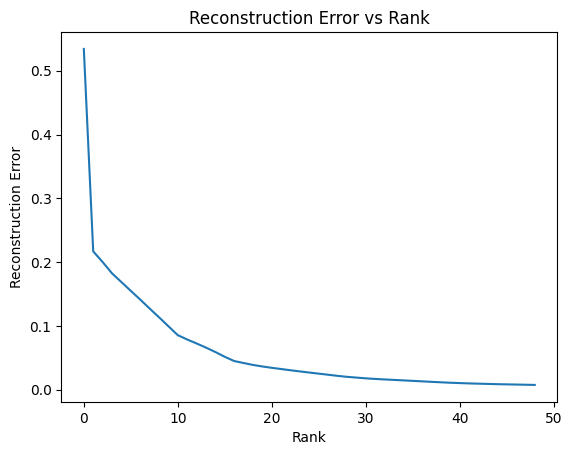

In [ ]:
plt.plot(errors)
plt.xlabel('Rank')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Rank')
plt.show()

Second Proposition
In this proposition, the tensor will be constructed using 4 modes: n_sample x (stream,chanel,jitter,src_ip,src_ip_mac) x (count,var,mean) x time

In [ ]:
L=['stream_1_count',
'stream_1_mean',
'stream_1_var',
'src_ip_1_count',
'src_ip_1_mean',
'src_ip_1_var',
'src_ip_mac_1_count',
'src_ip_mac_1_mean',
'src_ip_mac_1_var',
'channel_1_count',
'channel_1_mean',
'channel_1_var',
'stream_jitter_1_sum',
'stream_jitter_1_mean',
'stream_jitter_1_var',
'stream_5_count',
'stream_5_mean',
'stream_5_var',
'src_ip_5_count',
'src_ip_5_mean',
'src_ip_5_var',
'src_ip_mac_5_count',
'src_ip_mac_5_mean',
'src_ip_mac_5_var',
'channel_5_count',
'channel_5_mean',
'channel_5_var',
'stream_jitter_5_sum',
'stream_jitter_5_mean',
'stream_jitter_5_var',
'stream_10_count',
'stream_10_mean',
'stream_10_var',
'src_ip_10_count',
'src_ip_10_mean',
'src_ip_10_var',
'src_ip_mac_10_count',
'src_ip_mac_10_mean',
'src_ip_mac_10_var',
'channel_10_count',
'channel_10_mean',
'channel_10_var',
'stream_jitter_10_sum',
'stream_jitter_10_mean',
'stream_jitter_10_var',
'stream_30_count',
'stream_30_mean',
'stream_30_var',
'src_ip_30_count',
'src_ip_30_mean',
'src_ip_30_var',
'src_ip_mac_30_count',
'src_ip_mac_30_mean',
'src_ip_mac_30_var',
'channel_30_count',
'channel_30_mean',
'channel_30_var',
'stream_jitter_30_sum',
'stream_jitter_30_mean',
'stream_jitter_30_var',
'stream_60_count',
'stream_60_mean',
'stream_60_var',
'src_ip_60_count',
'src_ip_60_mean',
'src_ip_60_var',
'src_ip_mac_60_count',
'src_ip_mac_60_mean',
'src_ip_mac_60_var',
'channel_60_count',
'channel_60_mean',
'channel_60_var',
'stream_jitter_60_sum',
'stream_jitter_60_mean',
'stream_jitter_60_var']

In [ ]:
df_b_1.dropna(subset=L, inplace=True)
df_b_2.dropna(subset=L, inplace=True)
df_DDoS.dropna(subset=L, inplace=True)
df_Mirai.dropna(subset=L, inplace=True)

In [ ]:
data_2=df[L]

In [ ]:
data_2.shape

(356967, 75)

In [ ]:
def create_4d_tensor(df):
    # Dimensions
    features = ['stream', 'src_ip', 'src_ip_mac', 'channel', 'stream_jitter']
    metrics = ['count', 'mean', 'var']
    time_windows = [1, 5, 10, 30, 60]

    n_samples = df.shape[0]
    tensor = np.zeros((n_samples, len(features), len(metrics), len(time_windows)))

    for i, feature in enumerate(features):
        for j, metric in enumerate(metrics):
            for k, t in enumerate(time_windows):
                # Correction : pour stream_jitter, remplacer "count" par "sum"
                metric_name = "sum" if feature == "stream_jitter" and metric == "count" else metric
                col = f"{feature}_{t}_{metric_name}"
                tensor[:, i, j, k] = df[col].values

    return tensor


In [ ]:
tensor_2=create_4d_tensor(data_2)

In [ ]:
tensor_2.size

26772525

In [ ]:
tensor_2.shape

(356967, 5, 3, 5)

In [ ]:
#sparsity ratio
nonzero_elements = np.count_nonzero(tensor_2)
total_elements = tensor_2.size
sparsity_ratio = 1 - (nonzero_elements / total_elements)
print("Sparsity Ratio:", sparsity_ratio)

Sparsity Ratio: 0.07672671890305449


In [ ]:
#normalize the tensor
tensor_2_normalized=tensor_2/tl.norm(tensor_2)

In [ ]:
#CP and rank
Factors_list_2=[]
errors_2=[]
for rank in range(1, 50):
    factors_2 = parafac(tensor_2_normalized, rank=rank, init='random')
    Factors_list_2.append(factors)
    tensor_reconstructed_2 = tl.cp_to_tensor(factors_2)
    reconstruction_error_2 = np.linalg.norm(tensor_2_normalized - tensor_reconstructed_2)
    errors_2.append(reconstruction_error_2)

KeyboardInterrupt: 

In [ ]:
errors

[np.float64(0.5342919746635175),
 np.float64(0.21677619245882032),
 np.float64(0.2001344912712151),
 np.float64(0.182326267188525),
 np.float64(0.16867617862997933),
 np.float64(0.15488853897153373),
 np.float64(0.1412789222665309),
 np.float64(0.12722187190861092),
 np.float64(0.11352144074766543),
 np.float64(0.0994489408427728),
 np.float64(0.08544837494223002),
 np.float64(0.0785910558115986),
 np.float64(0.07240275576304284),
 np.float64(0.06588972639266345),
 np.float64(0.058967313056050574),
 np.float64(0.05149742190931927),
 np.float64(0.04485191442277998),
 np.float64(0.0417356517081249),
 np.float64(0.03872149288841718),
 np.float64(0.03631611724128039),
 np.float64(0.03419953542792261),
 np.float64(0.032304700016671586),
 np.float64(0.03034823457954339),
 np.float64(0.02854964089289282),
 np.float64(0.026775869807890425),
 np.float64(0.025057520655923725),
 np.float64(0.02334326705524162),
 np.float64(0.021606908309725423),
 np.float64(0.02006407944451555),
 np.float64(0.018

**Construction of the Flow based tensor**

In [6]:
#Tensor construction for flowbased_features
df1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic.pcap_Flow.csv') #skip bad lines
df2=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic1.pcap_Flow.csv') #skip bad lines
df3=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic2.pcap_Flow.csv')
df4=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic3.pcap_Flow.csv')
df5=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Anomalies_fbased/DDoS-HTTP_Flood-.pcap_Flow.csv')
df6=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Anomalies_fbased/DoS-HTTP_Flood.pcap_Flow.csv') #skip bad lines
 #skip bad lines

In [7]:
df1['Timestamp']=pd.to_datetime(df1['Timestamp'])
df2['Timestamp']=pd.to_datetime(df2['Timestamp'])
df3['Timestamp']=pd.to_datetime(df3['Timestamp'])
df4['Timestamp']=pd.to_datetime(df4['Timestamp'])
df5['Timestamp']=pd.to_datetime(df5['Timestamp'])
df6['Timestamp']=pd.to_datetime(df6['Timestamp'])

<ipython-input-7-784bfd6b29cb>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Timestamp']=pd.to_datetime(df1['Timestamp'])
<ipython-input-7-784bfd6b29cb>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Timestamp']=pd.to_datetime(df2['Timestamp'])
<ipython-input-7-784bfd6b29cb>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df4['Timestamp']=pd.to_datetime(df4['Timestamp'])
<ipython-input-7-784bfd6b29cb>:5: UserWarning: Parsing dates in %d/%m/%Y %I:%M:%S %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silen

In [8]:
df1['Jour']=df1['Timestamp'].dt.date
df2['Jour']=df2['Timestamp'].dt.date
df3['Jour']=df3['Timestamp'].dt.date
df4['Jour']=df4['Timestamp'].dt.date
df5['Jour']=df5['Timestamp'].dt.date
df6['Jour']=df6['Timestamp'].dt.date

In [9]:
df1['Jour']=pd.to_datetime(df1['Jour'])
df2['Jour']=pd.to_datetime(df2['Jour'])
df3['Jour']=pd.to_datetime(df3['Jour'])
df4['Jour']=pd.to_datetime(df4['Jour'])
df5['Jour']=pd.to_datetime(df5['Jour'])
df6['Jour']=pd.to_datetime(df6['Jour'])

In [10]:
# Création d'un sous-dataset pour le jour 2022-07-10 à partir de df1 et df2
df_ben_day_1 = pd.concat([
    df1[df1['Jour'] == '2022-07-10'],
    df2[df2['Jour'] == '2022-07-10']
], axis=0)

# Création d'un sous-dataset pour le jour 2022-08-10 à partir de df2, df3 et df4
df_ben_day_2 = pd.concat([
    df2[df2['Jour'] == '2022-08-10'],
    df3[df3['Jour'] == '2022-08-10'],
    df4[df4['Jour'] == '2022-08-10']
], axis=0)
df5_day_1 = df5[df5['Jour'] == '2022-09-14']
df5_day_2 = df5[df5['Jour'] == '2022-11-07']
df6_day_1 = df6[df6['Jour'] == '2022-08-08']
df6_day_2 = df6[df6['Jour'] == '2022-09-08']

In [11]:
df_ben_day_1.drop_duplicates(inplace=True)
df_ben_day_2.drop_duplicates(inplace=True)
df5_day_1.drop_duplicates(inplace=True)
df5_day_2.drop_duplicates(inplace=True)
df6_day_1.drop_duplicates(inplace=True)
df6_day_2.drop_duplicates(inplace=True)

<ipython-input-11-ba655dd153ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_day_1.drop_duplicates(inplace=True)
<ipython-input-11-ba655dd153ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_day_2.drop_duplicates(inplace=True)
<ipython-input-11-ba655dd153ea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6_day_1.drop_duplicates(inplace=True)
<ipython-input-11-ba655dd153ea>:6: SettingWithCopyWarning: 
A value is tryin

In [12]:
df_ben_day_1.dropna(inplace=True)
df_ben_day_2.dropna(inplace=True)
df5_day_1.dropna(inplace=True)
df5_day_2.dropna(inplace=True)
df6_day_1.dropna(inplace=True)
df6_day_2.dropna(inplace=True)

<ipython-input-12-8bffad585a43>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_day_1.dropna(inplace=True)
<ipython-input-12-8bffad585a43>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_day_2.dropna(inplace=True)
<ipython-input-12-8bffad585a43>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6_day_1.dropna(inplace=True)
<ipython-input-12-8bffad585a43>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [13]:
df_ben_day_1['Heure']=df_ben_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df_ben_day_2['Heure']=df_ben_day_2['Timestamp'].dt.strftime('%H:%M:%S')
df5_day_1['Heure']=df5_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df5_day_2['Heure']=df5_day_2['Timestamp'].dt.strftime('%H:%M:%S')
df6_day_1['Heure']=df6_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df6_day_2['Heure']=df6_day_2['Timestamp'].dt.strftime('%H:%M:%S')

<ipython-input-13-eeef53b692c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_day_1['Heure']=df5_day_1['Timestamp'].dt.strftime('%H:%M:%S')
<ipython-input-13-eeef53b692c3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_day_2['Heure']=df5_day_2['Timestamp'].dt.strftime('%H:%M:%S')
<ipython-input-13-eeef53b692c3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [14]:
df_ben_day_1['Heure']=pd.to_datetime(df_ben_day_1['Heure'])
df_ben_day_2['Heure']=pd.to_datetime(df_ben_day_2['Heure'])
df5_day_1['Heure']=pd.to_datetime(df5_day_1['Heure'])
df5_day_2['Heure']=pd.to_datetime(df5_day_2['Heure'])
df6_day_1['Heure']=pd.to_datetime(df6_day_1['Heure'])
df6_day_2['Heure']=pd.to_datetime(df6_day_2['Heure'])

<ipython-input-14-fa2eb6340e39>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ben_day_1['Heure']=pd.to_datetime(df_ben_day_1['Heure'])
<ipython-input-14-fa2eb6340e39>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ben_day_2['Heure']=pd.to_datetime(df_ben_day_2['Heure'])
<ipython-input-14-fa2eb6340e39>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df5_day_1['Heure']=pd.to_datetime(df5_day_1['Heure'])
<ipython-input-14-fa2eb6340e39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [15]:
df_ben_day_1['relative_time']=df_ben_day_1['Heure']-df_ben_day_1['Heure'].min()
df_ben_day_2['relative_time']=df_ben_day_2['Heure']-df_ben_day_2['Heure'].min()
df5_day_1['relative_time']=df5_day_1['Heure']-df5_day_1['Heure'].min()
df5_day_2['relative_time']=df5_day_2['Heure']-df5_day_2['Heure'].min()
df6_day_1['relative_time']=df6_day_1['Heure']-df6_day_1['Heure'].min()
df6_day_2['relative_time']=df6_day_2['Heure']-df6_day_2['Heure'].min()

<ipython-input-15-8e1a43985e18>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_day_1['relative_time']=df5_day_1['Heure']-df5_day_1['Heure'].min()
<ipython-input-15-8e1a43985e18>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_day_2['relative_time']=df5_day_2['Heure']-df5_day_2['Heure'].min()
<ipython-input-15-8e1a43985e18>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Some filtrations to reduce the data size

In [ ]:
#Keep just IP addresses which appears before 16h

mask_13h = (df_ben_day_2['Timestamp'].dt.hour <16 )
df_13h = df_ben_day_2[mask_13h]
df_autres = df_ben_day_2[~mask_13h]


dst_ip_13h_uniques = set(df_13h['Dst IP']) - set(df_autres['Dst IP'])


df_resultat = df_13h[df_13h['Dst IP'].isin(dst_ip_13h_uniques)]


In [16]:
df_ben_day_2.dropna(inplace=True)
df6_day_1.dropna(inplace=True)
df5_day_1.dropna(inplace=True)

<ipython-input-16-9a46ba7a70d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6_day_1.dropna(inplace=True)
<ipython-input-16-9a46ba7a70d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_day_1.dropna(inplace=True)


In [ ]:
ip_to_reduce = '192.168.137.131'
reduction_fraction = 0.09  # Garder 25% des apparitions

# Trouver les index où l'adresse IP apparaît
indexes_dst = df6_day_1[df6_day_1['Dst IP'] == ip_to_reduce].index

# Calculer combien d'éléments on veut garder
n_to_keep = int(len(indexes_dst) * reduction_fraction)

# Sélectionner aléatoirement les index à garder
indexes_to_keep = np.random.choice(indexes_dst, size=n_to_keep, replace=False)

# Créer un masque pour tout garder sauf les lignes à supprimer
mask = ~df6_day_1.index.isin(indexes_dst) | df6_day_1.index.isin(indexes_to_keep)

# Appliquer le filtre
df6_day_1_reduced = df6_day_1[mask].reset_index(drop=True)

print(f"Ancien nombre de lignes : {len(df6_day_1)}")
print(f"Nouveau nombre de lignes : {len(df6_day_1_reduced)}")


Ancien nombre de lignes : 860685
Nouveau nombre de lignes : 822232


In [ ]:
L_5_1=['192.168.137.41', '157.249.81.141', '109.95.152.166','192.168.137.4','192.168.137.89'
       ]
L_6_1=['192.168.137.131',
'108.138.125.109',
'54.91.82.76',
'3.136.72.65',
'52.92.210.242'
       ]

In [ ]:
data=pd.concat([df_resultat,df5_day_1[df5_day_1['Dst IP'].isin(L_5_1)],df6_day_1_reduced[df6_day_1_reduced['Dst IP'].isin(L_6_1)]],axis=0)

In [ ]:
data.shape

(21086, 87)

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data['Src IP'].nunique()

98

In [ ]:
#For experimentation perpose, we First consider the benign dataset iin which we have reduced the number of IP address


In [27]:
l=["52.46.149.20",
"52.27.254.108",
"54.201.2.24",
"18.201.5.172",
"54.209.44.8",
"34.239.216.180",
"52.31.161.248",
"44.238.43.136",
"173.255.250.75",
"192.168.137.58",
"47.90.209.117",
"47.254.89.110",
"161.117.254.158",
"52.216.95.35",
"142.251.41.46",
"192.168.137.207",
"54.173.75.186",
"54.205.158.199",
"54.201.239.48",
"51.79.79.175",
"3.212.48.2",
"35.175.71.102",
"192.168.137.148",
"52.31.220.16",
"255.255.255.255",
"52.17.204.228",
"192.168.137.35",
"54.193.143.35",
"35.185.101.66",
"3.12.33.198",
"8.0.6.4",
"142.251.163.188",
"52.43.232.245",
"54.188.27.243"

]

In [28]:
df_ben_day_2[df_ben_day_2['Dst IP'].isin(l)]['Src IP'].nunique()

98

In [29]:
df_ben_day_2[df_ben_day_2['Dst IP'].isin(l)]['Dst IP'].shape

(31490,)

In [30]:
print("Nb de valeurs infinies dans Flow Bytes/s:", np.isinf(df_ben_day_2['Flow Bytes/s']).sum())
print("Nb de valeurs infinies dans Flow Packets/s:", np.isinf(df_ben_day_2['Flow Packets/s']).sum())
print("Nb de valeurs infinies dans Flow Duration:", np.isinf(df_ben_day_2['Flow Duration']).sum())

print("Nb de NaN dans Flow Bytes/s:", df_ben_day_2['Flow Bytes/s'].isna().sum())
print("Nb de NaN dans Flow Packets/s:", df_ben_day_2['Flow Packets/s'].isna().sum())
print("Nb de NaN dans Flow Duration:", df_ben_day_2['Flow Duration'].isna().sum())

Nb de valeurs infinies dans Flow Bytes/s: 75
Nb de valeurs infinies dans Flow Packets/s: 75
Nb de valeurs infinies dans Flow Duration: 0
Nb de NaN dans Flow Bytes/s: 0
Nb de NaN dans Flow Packets/s: 0
Nb de NaN dans Flow Duration: 0


In [31]:
df_ben_day_2.replace([np.inf, -np.inf], np.nan, inplace=True)

Time-aware Tensor graph

In [32]:
def create_graph_tensor(df, window_size=300):
    # Extract unique source and destination IPs
    src_ips = df['Src IP'].unique()
    dst_ips = df['Dst IP'].unique()

    # Create mappings for src_ip and dst_ip to indices
    src_ip_to_idx = {ip: idx for idx, ip in enumerate(src_ips)}
    dst_ip_to_idx = {ip: idx for idx, ip in enumerate(dst_ips)}

    # Create time windows
    df['time_window'] = df['relative_time'].astype(np.int64) // (10**9 * window_size)
    time_windows = sorted(df['time_window'].unique())

    # Create adjacency tensor [time_windows, Src IP, Dst IP, features]
    tensor = np.zeros((len(time_windows), len(src_ips), len(dst_ips), 4),dtype=np.float32)  # 4 features (count, bytes, duration, packets)

    # Group by time window, source and destination
    for _, group in df.groupby(['time_window', 'Src IP', 'Dst IP']):
        t_idx = np.where(time_windows == group['time_window'].iloc[0])[0][0]
        src_idx = src_ip_to_idx[group['Src IP'].iloc[0]]
        dst_idx = dst_ip_to_idx[group['Dst IP'].iloc[0]]

        # Aggregated features
        tensor[t_idx, src_idx, dst_idx, 0] = len(group)  # count
        tensor[t_idx, src_idx, dst_idx, 1] = group['Flow Bytes/s'].sum()  # bytes
        tensor[t_idx, src_idx, dst_idx, 2] = group['Flow Duration'].mean()  # duration
        tensor[t_idx, src_idx, dst_idx, 3] = group['Flow Packets/s'].sum()  # packets

    return tensor, src_ip_to_idx, dst_ip_to_idx, time_windows

In [33]:
tensor, src_ip_to_idx, dst_ip_to_idx, time_windows=create_graph_tensor(df_ben_day_2[df_ben_day_2['Dst IP'].isin(l)])

<ipython-input-32-6afa49c576f4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_window'] = df['relative_time'].astype(np.int64) // (10**9 * window_size)


In [35]:
tensor.size

2932160

In [34]:
tensor.shape

(220, 98, 34, 4)

In [36]:
np.count_nonzero(tensor)

45804

In [ ]:
tensor.dtype

dtype('float32')

In [37]:
np.max(tensor)


np.float32(1469000000.0)

In [38]:
tensor_normalized=tensor/tl.norm(tensor)

In [42]:
Factors_list_3=[]
errors_3=[]
for rank in range(1, 50):
    factors = parafac(tensor_normalized, n_iter_max=500,rank=rank, init='random',tol=1e-6)
    Factors_list_3.append(factors)
    tensor_reconstructed = tl.cp_to_tensor(factors)
    reconstruction_error = tl.norm(tensor_normalized - tensor_reconstructed)
    errors_3.append(reconstruction_error)

/usr/local/lib/python3.11/dist-packages/tensorly/backend/__init__.py:202: RuntimeWarning: invalid value encountered in sqrt
  return getattr(


In [43]:
errors_3

[np.float32(0.69916344),
 np.float32(0.5780121),
 np.float32(0.5303106),
 np.float32(0.5060577),
 np.float32(0.48051015),
 np.float32(0.45585164),
 np.float32(0.4332258),
 np.float32(0.41270143),
 np.float32(0.38602912),
 np.float32(0.3561399),
 np.float32(0.33846286),
 np.float32(0.33550775),
 np.float32(0.3191543),
 np.float32(0.2597509),
 np.float32(0.3011254),
 np.float32(0.2577675),
 np.float32(0.23559193),
 np.float32(0.18471551),
 np.float32(0.20627092),
 np.float32(0.24869062),
 np.float32(0.1903401),
 np.float32(0.23149946),
 np.float32(0.13077575),
 np.float32(0.23265041),
 np.float32(0.150009),
 np.float32(0.18212463),
 np.float32(0.22177248),
 np.float32(0.17871048),
 np.float32(0.18223126),
 np.float32(0.08629526),
 np.float32(0.15881068),
 np.float32(0.088294856),
 np.float32(0.16772674),
 np.float32(0.08444639),
 np.float32(0.06902245),
 np.float32(0.113058075),
 np.float32(0.08345093),
 np.float32(0.11365604),
 np.float32(0.07194888),
 np.float32(0.06855563),
 np.float3

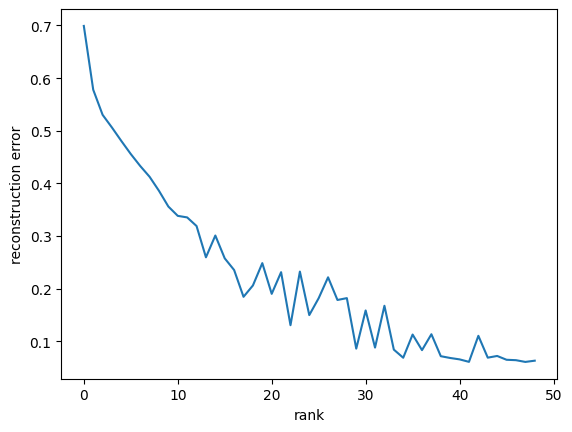

In [45]:
#compression graph
plt.plot(errors_3)
plt.xlabel('rank')
plt.ylabel('reconstruction error')
plt.show()

In [50]:
errors={}
for i in range(len(errors_3)):
    if errors_3[i]<0.15:
        errors[i] = errors_3[i]

In [51]:
errors

{22: np.float32(0.13077575),
 29: np.float32(0.08629526),
 31: np.float32(0.088294856),
 33: np.float32(0.08444639),
 34: np.float32(0.06902245),
 35: np.float32(0.113058075),
 36: np.float32(0.08345093),
 37: np.float32(0.11365604),
 38: np.float32(0.07194888),
 39: np.float32(0.06855563),
 40: np.float32(0.06590125),
 41: np.float32(0.061196048),
 42: np.float32(0.110656336),
 43: np.float32(0.06916561),
 44: np.float32(0.07239117),
 45: np.float32(0.06515299),
 46: np.float32(0.0643816),
 47: np.float32(0.06107239),
 48: np.float32(0.06343076)}

In [53]:
#resudual of each rank in errors
residual=[]
for key, value in errors.items():
    E=tensor_normalized-tl.cp_to_tensor(Factors_list_3[key])
    residual.append(E)

In [55]:
from tensorly import unfold, fold
from tensorly.tenalg import khatri_rao
from numpy.linalg import lstsq

def compute_residual_tensors(N, B, C, D):
    """
    Computes residual tensors for each time slice of a 4D tensor,
    projecting each slice into the space defined by CP factors B, C, D.

    Parameters:
    - N: 4D input tensor of shape (T, I, J, F) where:
        T = number of time windows
        I = number of Src IPs
        J = number of Dst IPs
        F = number of features
    - B, C, D: factor matrices from CP decomposition of the normal model
        Shapes: B (I, R), C (J, R), D (F, R)

    Returns:
    - residuals: List of 3D tensors (shape I×J×F), one per time slice,
                 representing the difference between the original and reconstructed slice.
    """
    T = N.shape[0]  # number of time windows
    R = B.shape[1]  # rank of the decomposition

    residuals = []

    # Compute Khatri-Rao product: (J*F, R)
    KRC = khatri_rao([D, C, B])  # Shape: (I*J*F, R)

    for t in range(T):
        # Step 1: Extract the slice for the current time window
        slice_tensor = tl.tensor(N[t])  # shape: (I, J, F)

        # Step 2: Vectorize the tensor by unfolding along mode-0 (shape: I*(J*F))
        slice_vec = unfold(slice_tensor, mode=0).reshape(-1)  # shape: I*J*F

        # Step 3: Solve for the latent vector a_t (shape: R)
        # Least squares: slice_vec ≈ KRC @ a_t
        a_t, _, _, _ = lstsq(KRC, slice_vec, rcond=None)

        # Step 4: Reconstruct the approximation of the original vector
        slice_hat_vec = KRC @ a_t  # shape: I*J*F

        # Step 5: Compute the residual vector
        residual_vec = slice_vec - slice_hat_vec  # shape: I*J*F

        # Step 6: Reshape back into 3D tensor: shape (I, J, F)
        residual_tensor = fold(residual_vec, mode=0, shape=N[t].shape)

        # Append this residual tensor
        residuals.append(residual_tensor)

    return residuals


In [66]:
df_ben_day_2['label']=0
df5_day_1['label']=1
df6_day_1['label']=1

<ipython-input-66-d58377128f5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5_day_1['label']=1
<ipython-input-66-d58377128f5f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6_day_1['label']=1


In [97]:
df=pd.concat([df_ben_day_2.sample(frac=0.001),df5_day_1,df6_day_1],axis=0)
print(df.shape)

(1122276, 88)


In [111]:
L_Dst=['52.53.92.145', '192.168.137.58', '8.8.4.4', '192.168.137.1',
       '255.255.255.255', '173.198.192.103', '8.8.8.8', '47.112.162.49',
       '192.168.137.186', '13.225.189.191', '239.255.255.250',
       '224.0.0.22', '192.168.137.86', '192.168.137.47', '44.235.174.159',
       '192.168.137.41', '34.158.253.218', '44.235.194.199',
       '52.210.251.230', '224.0.0.251', '192.168.137.128',
       '3.223.181.245', '44.199.80.228', '18.182.200.45',
       '192.168.137.133', '3.12.33.198', '51.79.79.175', '52.0.136.27',
       '13.225.196.108', '3.217.147.217', '34.239.216.180',
       '3.208.160.215', '172.253.62.188', '192.168.137.175',
       ]
L_Src=['192.168.137.132', '192.168.137.253','192.168.137.227',
       '192.168.137.131', '192.168.137.139', '192.168.137.133',
       '192.168.137.1', '192.168.137.83', '192.168.137.90',
       '192.168.137.154', '52.15.60.193', '192.168.137.61',
       '192.168.137.41', '192.168.137.207', '192.168.137.16',
       '109.95.152.66', '192.168.137.47', '192.168.137.172',
       '192.168.137.159', '192.168.137.175', '192.168.137.78',
       '195.88.50.100', '192.168.137.128', '192.168.137.76',
       '192.168.137.110', '192.168.137.35', '192.168.137.250',
       '192.168.137.51', '192.168.137.187', '192.168.137.210',
       '52.214.192.17', '192.168.137.39', '192.168.137.224',
       '192.168.137.31', '67.231.244.222', '192.168.137.68',
       '192.168.137.22', '192.168.137.82', '192.168.137.148',
       '192.168.137.135', '192.168.137.186', '8.8.4.4', '192.168.137.70',
       '192.168.137.3', '192.168.137.86', '192.168.137.62',
       '192.168.137.46', '192.168.137.245', '192.168.137.249',
       '192.168.137.176', '192.168.137.181', '192.168.137.192', '0.0.0.0',
       '157.249.81.141', '192.168.137.178', '35.86.13.17',
       '192.168.137.141', '192.168.137.64', '192.168.137.89',
       '192.168.137.225', '192.168.137.150', '192.168.137.238',
       '192.168.137.203', '13.225.196.108', '192.168.137.87',
       '192.168.137.191', '192.168.137.19', '142.251.32.67',
       '192.168.137.60', '192.168.137.4', '192.168.137.206',
       '52.51.193.92', '3.234.20.130', '3.12.33.198', '34.158.253.218',
       '192.168.137.167', '52.48.53.214', '44.232.212.4', '18.207.33.55',
       '192.168.137.123', '192.168.137.180', '34.158.0.131',
       '192.168.137.204', '47.88.56.147', '108.138.125.14',
       '52.94.237.71', '192.168.137.104', '35.76.66.254',
       '192.168.137.66', '108.138.125.198', '192.168.137.153',
       '35.185.101.66', '192.168.137.243', '192.168.137.239',
       '192.168.137.188', '192.168.137.185', '8.6.0.1', '195.88.50.98',
       '192.168.137.49', '192.168.137.136', '192.168.137.196',
       '192.168.137.69', '192.168.137.98', '54.188.27.243',
       '192.99.160.133', '192.168.137.95', '192.168.137.115',
       '192.168.137.17', '192.168.137.193', '192.168.137.164',
       '54.191.3.239', '182.92.131.196', '192.168.137.208']


In [112]:
df_exp=df[df['Src IP'].isin(L_Src) & df['Dst IP'].isin(L_Dst)]

In [119]:
for i in range(35):


,count
Dst IP,
192.168.137.211,655715
192.168.137.132,176745
192.168.137.66,68885
192.168.137.139,57308
192.168.137.235,44358
...,...
17.248.175.244,1
17.57.147.6,1
17.57.147.4,1


In [100]:
df['Src IP'].unique()

array(['192.168.137.132', '192.168.137.253', '192.168.137.227',
       '192.168.137.131', '192.168.137.139', '192.168.137.133',
       '192.168.137.1', '192.168.137.83', '192.168.137.90',
       '192.168.137.154', '52.15.60.193', '192.168.137.61',
       '192.168.137.41', '192.168.137.207', '192.168.137.16',
       '109.95.152.66', '192.168.137.47', '192.168.137.172',
       '192.168.137.159', '192.168.137.175', '192.168.137.78',
       '195.88.50.100', '192.168.137.128', '192.168.137.76',
       '192.168.137.110', '192.168.137.35', '192.168.137.250',
       '192.168.137.51', '192.168.137.187', '192.168.137.210',
       '52.214.192.17', '192.168.137.39', '192.168.137.224',
       '192.168.137.31', '67.231.244.222', '192.168.137.68',
       '192.168.137.22', '192.168.137.82', '192.168.137.148',
       '192.168.137.135', '192.168.137.186', '8.8.4.4', '192.168.137.70',
       '192.168.137.3', '192.168.137.86', '192.168.137.62',
       '192.168.137.46', '192.168.137.245', '192.168.137.249'

In [87]:
df_exp['label'].shape

(1634,)

In [88]:
tensor_2, src_ip_to_idx_2, dst_ip_to_idx_2, time_windows_2=create_graph_tensor(df_exp)

<ipython-input-32-6afa49c576f4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_window'] = df['relative_time'].astype(np.int64) // (10**9 * window_size)


In [89]:
tensor_2.shape

(16, 14, 12, 4)

Time-binned Tensor graph with adaptive resolution

In [ ]:
from datetime import timedelta

def create_adaptive_time_bins(df, min_bin_size=60, max_bin_size=300, activity_threshold=20):
    # The 'relative_time' column is already a timedelta, no need to convert
    #timestamps = pd.to_datetime(df['relative_time']).sort_values().tolist()
    timestamps = df['relative_time'].sort_values().tolist()

    bins = []
    current_bin_start = timestamps[0]
    current_events = []

    for ts in timestamps:
        current_events.append(ts)

        elapsed_time = (ts - current_bin_start).total_seconds()

        # Vérifie si on doit créer un bin
        if len(current_events) >= activity_threshold or elapsed_time >= max_bin_size:
            if len(current_events) >= activity_threshold:
                # Forte activité ➜ plus petit bin
                avg_spacing = elapsed_time / len(current_events)
                bin_size = min(max_bin_size, max(min_bin_size, avg_spacing * 5))
            else:
                # Faible activité ➜ grand bin
                bin_size = max_bin_size

            bin_end = current_bin_start + timedelta(seconds=bin_size)
            bins.append((current_bin_start, bin_end))

            # Réinitialiser pour le bin suivant
            current_bin_start = bin_end
            current_events = [e for e in current_events if e >= bin_end]

    # Traiter les éventuels événements restants
    if current_bin_start < timestamps[-1]:
        bins.append((current_bin_start, timestamps[-1]))

    return bins

In [ ]:
def create_graph_tensor_with_bins(df, bins):
    # 1. Obtenir tous les IPs uniques
    all_ips = set(df['Src IP'].unique()) | set(df['Dst IP'].unique())
    ip_to_idx = {ip: idx for idx, ip in enumerate(sorted(all_ips))}

    n_devices = len(all_ips)
    n_features = 4  # count, bytes, duration, packets
    n_bins = len(bins)

    # 2. Initialiser le tenseur [temps, src, dst, features]
    tensor = np.zeros((n_bins, n_devices, n_devices, n_features))

    # 3. Associer chaque ligne à un bin temporel
    df['bin_index'] = -1  # initialisation

    for i, (start, end) in enumerate(bins):
        mask = (df['relative_time'] >= start) & (df['relative_time'] < end)
        df.loc[mask, 'bin_index'] = i

    # 4. Groupement et remplissage du tenseur
    for _, group in df[df['bin_index'] != -1].groupby(['bin_index', 'Src IP', 'Dst IP']):
        bin_idx = group['bin_index'].iloc[0]
        src_idx = ip_to_idx[group['Src IP'].iloc[0]]
        dst_idx = ip_to_idx[group['Dst IP'].iloc[0]]

        tensor[bin_idx, src_idx, dst_idx, 0] = len(group)  # count
        tensor[bin_idx, src_idx, dst_idx, 1] = group['Flow Bytes/s'].sum()
        tensor[bin_idx, src_idx, dst_idx, 2] = group['Flow Duration'].mean()
        tensor[bin_idx, src_idx, dst_idx, 3] = group['Flow Packets/s'].sum()

    return tensor, ip_to_idx, bins


Some Methods overview tha I will explain
.. Tensor residuals for anomalies detection

-Low-rank tensor using a tensor decomposition method
-residuals calculation on the new dataset
-anomalies detection using : either a supervised learning or an unsupervised learning

..Nonnegative Tensor factorization
-
.. Tensor Robust PCA
..